Quick analysis

In [1]:
#!/usr/bin/env python3
# %matplotlib widget
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import tinydb as db
from tinydb.storages import MemoryStorage
import matplotlib.pyplot as plt
# plt.style.use('../clint.mpl')
from matplotlib.colors import LogNorm

import boost_histogram as bh
import pickle as pl

from pygama import DataGroup
import pygama.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf

In [2]:
dg = DataGroup('$CAGE_SW/processing/cage.json', load=True)
run = 66
# cycle = 1481
str_query = f'run=={run} and skip==False'
# str_query = f'cycle=={cycle} and skip==False'
dg.fileDB.query(str_query, inplace=True)
# view_cols = ['runtype', 'run', 'cycle', 'startTime', 'runtime', 'threshold']
print(dg.fileDB['runtype'])
# print(dg.fileDB)

dsp_id = '02'

878    alp
879    alp
880    alp
881    alp
882    alp
883    alp
884    alp
885    alp
886    alp
887    alp
Name: runtype, dtype: object


In [3]:
etype = 'trapEftp'

In [4]:
if etype=='trapEftp':
    print('hi! that worked')
e_unit = ' (uncal)'

name = f'{etype+e_unit}'
print(name)

hi! that worked
trapEftp (uncal)


In [5]:
# Working with dsp or hit files?

hit = True 
# hit = False #ie working with dsp files

In [6]:
# Working with calibrated or uncalibrated data?

cal = True #calibrated data
# cal = False #uncalibrated data

In [7]:
# Working in your own directory or with the CAGE_lh5 directory?

# user = False # CAGE_lh5 directory
user = True # hit filesin my personal directory

In [8]:
#get runtime, startime, runtype

runtype_list = np.array(dg.fileDB['runtype'])
runtype = runtype_list[0]

rt_min = dg.fileDB['runtime'].sum()
u_start = dg.fileDB.iloc[0]['startTime']
t_start = pd.to_datetime(u_start, unit='s') # str
print(f'Runtime: {rt_min} minutes')

Runtime: 299.8561205073331 minutes


In [9]:
# get scan position

if runtype == 'alp':
    alphaDB = pd.read_hdf(os.path.expandvars('$CAGE_SW/processing/alphaDB.h5'))
    scan_pos = alphaDB.loc[alphaDB['run']==run]
    radius = np.array(scan_pos['radius'])[0]
    angle = np.array(scan_pos['source'])[0]
    angle_det = 270 + angle
    print(f'Radius: {radius}; Source Angle: {angle_det}')
    
else:
    radius = 'n/a'
    angle = 'n/a'
    angle_det = 'n/a'

Radius: 12.5; Source Angle: 90.0


In [10]:
# Get relevant files

lh5_dir = dg.lh5_user_dir if user else dg.lh5_dir
# lh5_dir = '/global/homes/g/gothman/projecta/CAGE_lh5_joule'
print(lh5_dir)

# if hit files
if hit == True:
    file_list = lh5_dir + dg.fileDB['hit_path'] + '/' + dg.fileDB['hit_file']
    
else:
    file_list = lh5_dir + dg.fileDB['dsp_path'] + '/' + dg.fileDB['dsp_file']
    
print(file_list)

/global/project/projectdirs/legend/users/gothman/CAGE/
878    /global/project/projectdirs/legend/users/gothm...
879    /global/project/projectdirs/legend/users/gothm...
880    /global/project/projectdirs/legend/users/gothm...
881    /global/project/projectdirs/legend/users/gothm...
882    /global/project/projectdirs/legend/users/gothm...
883    /global/project/projectdirs/legend/users/gothm...
884    /global/project/projectdirs/legend/users/gothm...
885    /global/project/projectdirs/legend/users/gothm...
886    /global/project/projectdirs/legend/users/gothm...
887    /global/project/projectdirs/legend/users/gothm...
dtype: object


In [11]:
# Create a dataframe

if (cal == True) and (hit == True):
#     df = lh5.load_dfs(file_list, ['energy', 'trapEftp', 'trapEftp_cal', 'bl','bl_sig'], 'ORSIS3302DecoderForEnergy/hit')
    df = lh5.load_dfs(file_list, ['energy', 'trapEmax', 'trapEftp', 'trapEftp_cal', 'bl','bl_sig', 'bl_slope', 'lf_max', 'A_10','AoE', 'dcr', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/hit')
    
elif (cal == True) and (hit == False):
    df = lh5.load_dfs(file_list, ['energy', 'trapEmax', 'trapEmax_cal', 'bl','bl_sig','A_10','AoE', 'dcr_raw', 'dcr_ftp', 'dcr_max', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/dsp')

elif (cal == False) and (hit == True):
    df = lh5.load_dfs(file_list, ['energy', 'trapEmax', 'bl','bl_sig','A_10','AoE', 'ts_sec', 'dcr_raw', 'dcr_ftp', 'dcr_max', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/hit')
    
elif (cal == False) and (hit == False):
    # df = lh5.load_dfs(file_list, ['energy', 'trapEmax', 'bl','bl_sig','A_10','AoE', 'dcr_raw', 'dcr_ftp', 'dcr_max', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/dsp')
    df = lh5.load_dfs(file_list, ['energy', 'trapEmax', 'trapEftp', 'bl','bl_sig', 'bl_slope', 'lf_max', 'A_10','AoE', 'dcr', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/dsp')


else:
    print('dont know what to do here! need to specify if working with calibrated/uncalibrated data, or dsp/hit files')

# df_hit = lh5.load_dfs(file_list, ['trapEmax', 'trapEmax_cal', 'bl','bl_sig','A_10','AoE', 'ts_sec', 'dcr_raw', 'dcr_ftp', 'dcr_max', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/hit')
# df_hit = lh5.load_dfs(alpha_hit_list, ['trapEmax', 'bl','bl_sig','A_10','ts_sec', 'dcr_raw'], 'ORSIS3302DecoderForEnergy/hit')
# print(df_hit)
# print(df_hit.columns)

# dsc = df[['bl','bl_sig','A_10','AoE', 'dcr_raw', 'dcr_ftp', 'dcr_max']].describe()
# dsc = df[['bl','bl_sig','A_10', 'dcr']].describe()
# print(dsc)

loading data for /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run66_cyc880_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run66_cyc881_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run66_cyc882_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run66_cyc883_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run66_cyc884_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run66_cyc885_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run66_cyc886_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run66_cyc887_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run66_cyc888_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run66_cyc889_hit.lh5


In [12]:
# select energy type

#trapEmax (uncal)
# etype = 'trapEmax'
# elo, ehi, epb = 0, 3000, 1
# blo, bhi, bpb = 0, 10000, 100

#trapEmax_cal (cal)
# etype = 'trapEmax_cal'
# elo, ehi, epb = 0, 5000, 10

# onboard energy
# etype = 'energy'
# elo, ehi, epb = 0, 1000000, 100

# # trapEftp (uncal)
# etype = 'trapEftp'
# elo, ehi, epb = 0, 10000, 10

# trapEftp_cal (cal)
etype = 'trapEftp_cal'
elo, ehi, epb = 0, 6000, 10




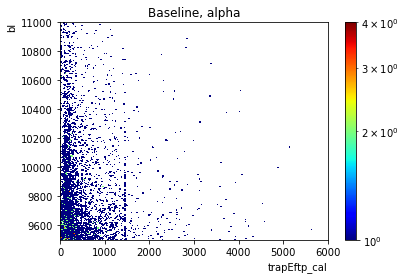

In [13]:
# Baseline vs E
# %matplotlib widget

blo, bhi, bpb = 9500, 11000, 1
nbx = int((ehi-elo)/epb)
nby = int((bhi-blo)/bpb)

h = plt.hist2d(df[etype], df['bl'], bins=[nbx,nby],
                       range=[[elo, ehi], [blo, bhi]], cmap='jet')

cb = plt.colorbar(h[3], ax=plt.gca())
plt.xlabel(f'{etype}', ha='right', x=1)
plt.ylabel('bl', ha='right', y=1)
plt.title('Baseline, alpha')
# plt.tight_layout()
plt.show()

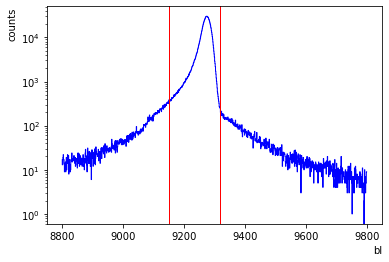

In [14]:
blo, bhi, bpb = 8800, 9800, 1
nbx = int((bhi-blo)/bpb)

bl_hist, bins = np.histogram(df['bl'], bins=nbx,
                range=[blo, bhi])

plt.semilogy(bins[1:], bl_hist, ds='steps', c='b', lw=1)

bl_cut_lo, bl_cut_hi = 9150,9320

plt.axvline(bl_cut_lo, c='r', lw=1)
plt.axvline(bl_cut_hi, c='r', lw=1)

plt.xlabel('bl', ha='right', x=1)
plt.ylabel('counts', ha='right', y=1)
plt.show()

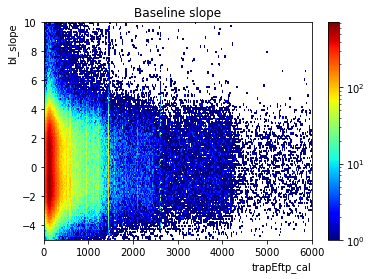

In [15]:
# Baseline vs E

bslo, bshi, bspb = -5, 10, 0.1
nbx = int((ehi-elo)/epb)
nby = int((bshi-bslo)/bspb)

h = plt.hist2d(df[etype], df['bl_slope'], bins=[nbx,nby],
                       range=[[elo, ehi], [bslo, bshi]], cmap='jet', norm=LogNorm())

cb = plt.colorbar(h[3], ax=plt.gca())
plt.xlabel(f'{etype}', ha='right', x=1)
plt.ylabel('bl_slope', ha='right', y=1)
plt.title('Baseline slope')
# plt.tight_layout()
plt.show()

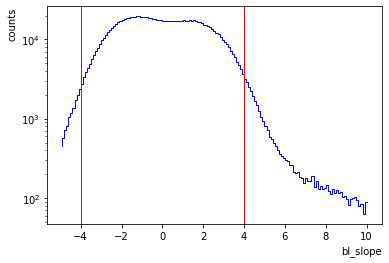

In [16]:
bslo, bshi, bspb = -5, 10, 0.1
nbx = int((bshi-bslo)/bspb)

bl_slope_hist, bins = np.histogram(df['bl_slope'], bins=nbx,
                range=[bslo, bshi])

plt.semilogy(bins[1:], bl_slope_hist, ds='steps', c='b', lw=1)

bl_slo_cut_lo, bl_slo_cut_hi = -4,4

plt.axvline(bl_slo_cut_lo, c='r', lw=1)
plt.axvline(bl_slo_cut_hi, c='r', lw=1)

plt.xlabel('bl_slope', ha='right', x=1)
plt.ylabel('counts', ha='right', y=1)
plt.show()

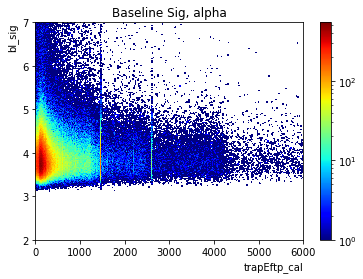

In [17]:
# Baseline vs E

bsiglo, bsighi, bsigpb = 2, 7, 0.01
nbx = int((ehi-elo)/epb)
nby = int((bsighi-bsiglo)/bsigpb)

h = plt.hist2d(df[etype], df['bl_sig'], bins=[nbx,nby],
                       range=[[elo, ehi], [bsiglo, bsighi]], cmap='jet', norm=LogNorm())

cb = plt.colorbar(h[3], ax=plt.gca())
plt.xlabel(f'{etype}', ha='right', x=1)
plt.ylabel('bl_sig', ha='right', y=1)
plt.title('Baseline Sig, alpha')
# plt.tight_layout()
plt.show()

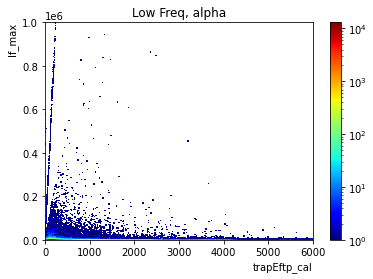

In [18]:
# Baseline vs E
elo, ehi, epb = 0, 6000, 10
lf_lo, lf_hi, lf_pb = 0, 1000000, 1000
nbx = int((ehi-elo)/epb)
nby = int((lf_hi-lf_lo)/lf_pb)

h = plt.hist2d(df[etype], df['lf_max'], bins=[nbx,nby],
                       range=[[elo, ehi], [lf_lo, lf_hi]], cmap='jet', norm=LogNorm())

cb = plt.colorbar(h[3], ax=plt.gca())
plt.xlabel(f'{etype}', ha='right', x=1)
plt.ylabel('lf_max', ha='right', y=1)
plt.title('Low Freq, alpha')
# plt.tight_layout()
plt.show()

In [19]:
# # Baseline vs E
# elo, ehi, epb = 0, 10000, 10
# lf_lo, lf_hi, lf_pb = 0, 5000000, 1000
# nbx = int((ehi-elo)/epb)
# nby = int((lf_hi-lf_lo)/lf_pb)

# h = plt.hist2d(df['ts_s'], df['lf_max'], bins=[nbx,nby],
#                        range=[[elo, ehi], [lf_lo, lf_hi]], cmap='jet', norm=LogNorm())

# cb = plt.colorbar(h[3], ax=plt.gca())
# plt.xlabel(f'{etype}', ha='right', x=1)
# plt.ylabel('lf_max', ha='right', y=1)
# plt.title('Low Freq, alpha')
# # plt.tight_layout()
# plt.show()

In [20]:
# use baseline cut
df_cut = df.query(f'bl > {bl_cut_lo} and bl < {bl_cut_hi}').copy()


#create dcr/E 
# df_cut['dcr_norm'] = df_cut['dcr'] / df_cut['trapEftp']

#create A/E cal 
# df_cut['AoE_cal'] = df_cut['A_10'] / df_cut['trapEftp_cal']

#creat new DCR
# const = 0.0555
# df_cut['dcr_linoff'] = df_cut['dcr_raw'] + const*df_cut['trapEmax']

# #create 10-90
# df_cut['10-90'] = df_cut['tp_90']- df_cut['tp_10']

# #create 50-90
# df_cut['50-90'] = df_cut['tp_90']- df_cut['tp_50']

#create 0-50
# df_cut['tp0_50'] = df_cut['tp_50']- df_cut['tp_0']

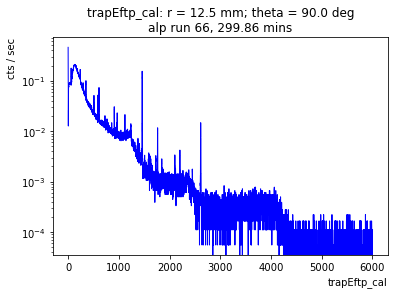

In [21]:
# %matplotlib widget
etype = 'trapEftp_cal'
# Make energy spectrum
# elo, ehi, epb = 2775, 2840, 1 #1460 pk uncal trapEmax
# elo, ehi, epb = 0, 5000000, 100 # basically entire range, rawe parameter ("energy")
# elo, ehi, epb = 1440000, 1470000, 100 # 1460 pk, rawe parameter ("energy")
# elo, ehi, epb = 2680000, 2720000, 10 # 2615 peak, rawe parameter ("energy")
# elo, ehi, epb = 2000000, 2500000, 100 # where alphas are in run 117, rawe parameter ("energy")
# elo, ehi, epb = 0, 10000, 10 #trapEftp
# elo, ehi, epb = 100, 20000, 10 #trapEftp uncal


# elo, ehi, epb = 0, 3000, 10
elo, ehi, epb = 0, 6000, 1 #trapEftp_cal
        

nbx = int((ehi-elo)/epb)

energy_hist, bins = np.histogram(df_cut[etype], bins=nbx,
                range=[elo, ehi])
energy_rt = np.divide(energy_hist, rt_min * 60)

plt.semilogy(bins[1:], energy_rt, ds='steps', c='b', lw=1) #, label=f'{etype}'

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('cts / sec', ha='right', y=1)
# plt.legend()
plt.title(f'{etype}: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
# plt.savefig(f'./plots/normScan/{runtype}_energy_run{run}.pdf', dpi=200)
# plt.xlim(20,80)
plt.show()

In [22]:
# # Make calibrated energy spectrum
# elo, ehi, epb = 0, 8000, 10
# # elo, ehi, epb = 0, 3000, 10
# # elo, ehi, epb = 0, 6000, 10
        

# nbx = int((ehi-elo)/epb)

# energy_hist, bins = np.histogram(df_cut['trapEmax_cal'], bins=nbx,
#                 range=[elo, ehi])
# energy_rt = np.divide(energy_hist, rt_min * 60)

# plt.semilogy(bins[1:], energy_rt, ds='steps', c='b', lw=1) #, label=f'{etype}'

# plt.xlabel(etype, ha='right', x=1)
# plt.ylabel('cts / sec', ha='right', y=1)
# # plt.legend()
# plt.title(f'{etype}: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
# plt.savefig(f'./plots/normScan/{runtype}_energy_run{run}.pdf', dpi=200)
# plt.show()

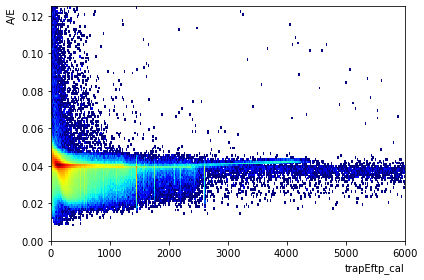

In [23]:
# Alpha A/E
alo, ahi, apb = 0.0, 0.125, 0.001
# elo, ehi, epb = 0, 10000, 10
# elo, ehi, epb = 0, 3000, 10
elo, ehi, epb = 0, 6000, 10
        

nbx = int((ehi-elo)/epb)
nby = int((ahi-alo)/apb)

h = plt.hist2d(df_cut[etype], df_cut['AoE'], bins=[nbx,nby],
                range=[[elo, ehi], [alo, ahi]], cmap='jet', norm=LogNorm())

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('A/E', ha='right', y=1)
# plt.legend()
# plt.title(f'A/E: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_a10oE_run{run}.png', dpi=200)
plt.show()

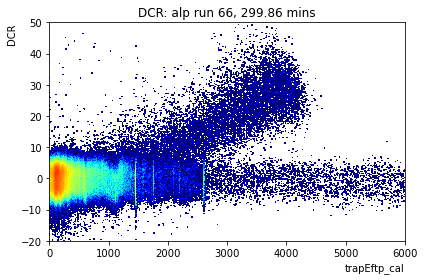

In [24]:
# DCR vs E
# etype = 'trapEmax'
# elo, ehi, epb = 500, 1500, 10
elo, ehi, epb = 0, 6000, 10
# elo, ehi, epb = 0, 20000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -10., 30, 0.1
dlo, dhi, dpb = -20., 50, 0.1 #dsp_id= 02
nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

alpha_dcr_hist = plt.hist2d(df_cut[etype], df_cut['dcr'], bins=[nbx,nby],
                range=[[elo, ehi], [dlo, dhi]], cmap='jet', norm=LogNorm())

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('DCR', ha='right', y=1)
plt.title(f'DCR: {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_dcr_norm_run{run}.png', dpi=200)
plt.show()

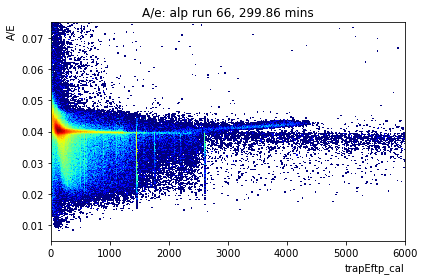

In [25]:
# AoE vs E
# etype = 'trapEmax'
# elo, ehi, epb = 500, 1500, 10
elo, ehi, epb = 0, 6000, 10
# elo, ehi, epb = 0, 20000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -10., 30, 0.1
alo, ahi, apb= 0.005, 0.075, 0.0001
nbx = int((ehi-elo)/epb)
nby = int((ahi-alo)/apb)

alpha_dcr_hist = plt.hist2d(df_cut[etype], df_cut['AoE'], bins=[nbx,nby],
                range=[[elo, ehi], [alo, ahi]], cmap='jet', norm=LogNorm())

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('A/E', ha='right', y=1)
plt.title(f'A/e: {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_dcr_norm_run{run}.png', dpi=200)
plt.show()

In [26]:
# DCR_norm vs E
# etype = 'trapEmax'
elo, ehi, epb = 0, 6000, 10
# elo, ehi, epb = 0, 10000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
dlo, dhi, dpb = -0.001, 0.02, 0.00005

nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

alpha_dcr_hist = plt.hist2d(df_cut[etype], df_cut['dcr_norm'], bins=[nbx,nby],
                range=[[elo, ehi], [dlo, dhi]], cmap='jet', norm=LogNorm())

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('DCR/trapEftp', ha='right', y=1)
plt.title(f'DCR: {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_dcr_norm_run{run}.png', dpi=200)
plt.show()

KeyError: 'dcr_norm'

In [27]:
#creat new DCR
# const = 0.0011 #dsp_01
const  = 0.0002 #dsp_02
df_cut['dcr_linoff'] = df_cut['dcr'] + const*df_cut['trapEftp']

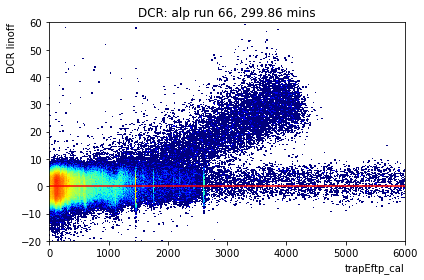

In [28]:
# DCR_norm vs E
# etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 6000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -0.004, 0.02, 0.00005
dlo, dhi, dpb = -20., 60, 0.1 #dsp_id= 02
# dlo, dhi, dpb = -0.1, 0.05, 0.00005 

nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

alpha_dcr_hist = plt.hist2d(df_cut[etype], df_cut['dcr_linoff'], bins=[nbx,nby],
                range=[[elo, ehi], [dlo, dhi]], cmap='jet', norm=LogNorm())
hline = plt.hlines(0, elo, ehi, colors='r')

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('DCR linoff', ha='right', y=1)
plt.title(f'DCR: {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_dcr_norm_run{run}.png', dpi=200)
plt.show()

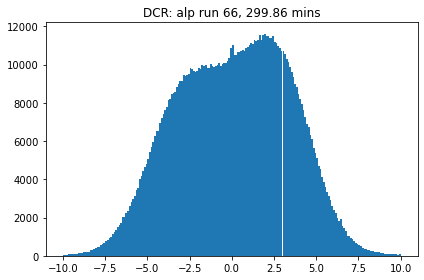

In [33]:
#1d DCR hist
dlo, dhi, dpb = -10., 10, 0.1 #dsp_id= 02
nbx = int((dhi-dlo)/dpb)

alpha_1d_dcr_hist = plt.hist(df_cut['dcr_linoff'], bins=nbx, range=[dlo, dhi])

plt.title(f'DCR: {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_dcr_norm_run{run}.png', dpi=200)
plt.show()

In [ ]:
#creat new DCR
const = -0.0003
const2 = -0.0000003
# const2 = -0.0000000000003
df_cut['dcr_uncal'] = df_cut['dcr'] + const*(df_cut['trapEftp']) + const2*(df_cut['trapEftp'])**2 

In [ ]:
#creat new DCR
const = -0.0015
const2 = -0.0000015
# const2 = -0.0000000000003
df_cut['dcr_new'] = df_cut['dcr'] + const*(df_cut['trapEftp_cal']) + const2*(df_cut['trapEftp_cal'])**2 

In [ ]:
# DCR_norm vs E
# etype = 'trapEmax'
elo, ehi, epb = 0, 6000, 10
# elo, ehi, epb = 0, 10000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
dlo, dhi, dpb = -20., 60, 0.1
# dlo, dhi, dpb = -0.1, 0.05, 0.00005 

nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

alpha_dcr_hist = plt.hist2d(df_cut[etype], df_cut['dcr_new'], bins=[nbx,nby],
                range=[[elo, ehi], [dlo, dhi]], cmap='jet', norm=LogNorm())

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('DCR-corrected', ha='right', y=1)
plt.title(f'DCR (corrected): {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_dcr_norm_run{run}.png', dpi=200)
plt.show()

In [ ]:
# DCR_norm vs E
# etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 10000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
dlo, dhi, dpb = -20., 60, 0.1
# dlo, dhi, dpb = -0.1, 0.05, 0.00005 

nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

alpha_dcr_hist = plt.hist2d(df_cut[etype], df_cut['dcr_uncal'], bins=[nbx,nby],
                range=[[elo, ehi], [dlo, dhi]], cmap='jet', norm=LogNorm())

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('DCR-corrected', ha='right', y=1)
plt.title(f'DCR (corrected): {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_dcr_norm_run{run}.png', dpi=200)
plt.show()

In [ ]:
# DCR vs 0-50


dlo, dhi, dpb = -30., 60, 0.1
tlo, thi, tpb = -0, 800, 10

nbx = int((dhi-dlo)/dpb)
nby = int((thi-tlo)/tpb)

alpha_dcr_hist = plt.hist2d(df_cut['dcr_new'], df_cut['tp0_50'], bins=[nbx,nby],
                range=[[dlo, dhi], [tlo, thi]], cmap='jet', norm=LogNorm()) #

plt.xlabel('DCR (arb)', ha='right', x=1)
plt.ylabel('tp 0-50 (ns)', ha='right', y=1)
plt.title(f'DCR vs 0-50% rise time: r = {radius} mm; theta = {angle_det} deg\n {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_tp0_50_vs_dcr_linoffset_run{run}.png', dpi=200)
plt.show()

In [ ]:
# DCR vs A/E
alo, ahi, apb = 0.0, 0.125, 0.001
dlo, dhi, dpb = -30., 60, 0.5

nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

alpha_dcr_hist = plt.hist2d(df_cut['AoE'], df_cut['dcr_new'], bins=[nbx,nby],
                range=[[alo, ahi], [dlo, dhi]], cmap='jet', norm=LogNorm())

plt.xlabel('A/E', ha='right', x=1)
plt.ylabel('DCR', ha='right', y=1)
plt.title(f'DCR: {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_dcr_norm_run{run}.png', dpi=200)
plt.show()

In [ ]:
# old_dcr_cut = df_cut.query('trapEmax > 5000 and trapEmax < 15000 and dcr_norm > -0.0515 and dcr_norm < -0.02').copy()
# len(old_dcr_cut)

In [ ]:
# DCR new vs E
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 10000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -0.1, 0.025, 0.0005

dlo, dhi, dpb = -0.004, 0.02, 0.00005

nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

alpha_dcr_hist = plt.hist2d(df_cut['trapEmax'], df_cut['dcr_linoff'], bins=[nbx,nby],
                range=[[elo, ehi], [dlo, dhi]], cmap='jet', norm=LogNorm()) #

plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('DCR_linoffset', ha='right', y=1)
plt.title(f'DCR: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_dcr_linoffset_run{run}.png', dpi=200)
plt.show()

In [ ]:
#creat new DCR
const = -0.0225
df_cut['dcr_new'] = df_cut['dcr_raw'] + const*df_cut['trapEmax']

In [ ]:
# DCR new vs E
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 25000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -0.1, 0.025, 0.0005

dlo, dhi, dpb = -100, 300, 0.6

nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

alpha_dcr_hist = plt.hist2d(df_cut['trapEmax'], df_cut['dcr_new'], bins=[nbx,nby],
                range=[[elo, ehi], [dlo, dhi]], cmap='jet', norm=LogNorm()) #

plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('DCR_linoffset', ha='right', y=1)
plt.title(f'DCR: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_dcr_linoffset_run{run}.png', dpi=200)
plt.show()

In [ ]:
# DCR 1D hist
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 15000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -0.1, 0.025, 0.0005

# dlo, dhi, dpb = 0, 200, 1
dlo, dhi, dpb = -200, 300, 0.6

nbx = int((dhi-dlo)/dpb)

dcr_hist, bins = np.histogram(df_cut['dcr_linoff'], bins=nbx,
                range=[dlo, dhi])

plt.semilogy(bins[1:], dcr_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'



# plt.legend()
plt.xlabel('DCR_linoffset', ha='right', y=1)
plt.ylabel('cts / sec', ha='right', y=1)
plt.title(f'DCR: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_1d_dcr_linoffset_run{run}.png', dpi=200)
plt.show()

In [ ]:
# DCR vs A/E
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 25000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -0.1, 0.025, 0.0005

# alo, ahi, apb = 0.0, 0.09, 0.0001
# dlo, dhi, dpb = -100, 300, 0.6

#for early centering runs 
alo, ahi, apb = 0.02, 0.1, 0.0001
dlo, dhi, dpb = -100, 500, 0.6
# dlo, dhi, dpb = 15, 300, 0.6

nbx = int((ahi-alo)/apb)
nby = int((dhi-dlo)/dpb)

alpha_dcr_hist = plt.hist2d(df_cut['AoE'], df_cut['dcr_linoff'], bins=[nbx,nby],
                range=[[alo, ahi], [dlo, dhi]], cmap='jet', norm=LogNorm()) #

plt.xlabel('A/E', ha='right', x=1)
plt.ylabel('DCR_linoffset', ha='right', y=1)
plt.title(f'DCR vs A/E: r = {radius} mm; theta = {angle_det} deg\n {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_a10oE_vs_dcr_linoffset_run{run}.png', dpi=200)
plt.show()

In [ ]:
# DCR vs 0-50


dlo, dhi, dpb = -100, 200, 0.6
tlo, thi, tpb = -0, 700, 10

nbx = int((dhi-dlo)/dpb)
nby = int((thi-tlo)/tpb)

alpha_dcr_hist = plt.hist2d(df_cut['dcr_linoff'], df_cut['tp0_50'], bins=[nbx,nby],
                range=[[dlo, dhi], [tlo, thi]], cmap='jet', norm=LogNorm()) #

plt.xlabel('DCR (arb)', ha='right', x=1)
plt.ylabel('tp 0-50 (ns)', ha='right', y=1)
plt.title(f'DCR vs 0-50% rise time: r = {radius} mm; theta = {angle_det} deg\n {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_tp0_50_vs_dcr_linoffset_run{run}.png', dpi=200)
plt.show()

In [ ]:
# alpha_cut = 'dcr_linoff > 25 and dcr_linoff < 200 and tp0_50 > 100 and tp0_50 < 400 and trapEmax < 12000'
# alpha_cut = 'dcr_linoff > 0 and dcr_linoff < 200 and tp0_50 > 100 and tp0_50 < 400 and trapEmax < 12000'
alpha_cut = 'dcr_linoff > 0 and dcr_linoff < 200 and tp0_50 > 100 and tp0_50 < 400 and trapEmax < 12000'
new_dcr_cut = df_cut.query(alpha_cut).copy()
len(new_dcr_cut)

In [ ]:
# DCR vs A/E
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 25000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -0.1, 0.025, 0.0005

alo, ahi, apb = 0.0, 0.09, 0.0001
dlo, dhi, dpb = -100, 300, 0.6

nbx = int((ahi-alo)/apb)
nby = int((dhi-dlo)/dpb)

alpha_dcr_hist = plt.hist2d(new_dcr_cut['AoE'], new_dcr_cut['dcr_linoff'], bins=[nbx,nby],
                range=[[alo, ahi], [dlo, dhi]], cmap='jet', norm=LogNorm()) #

plt.xlabel('A/E', ha='right', x=1)
plt.ylabel('DCR_linoffset', ha='right', y=1)
plt.title(f'DCR vs A/E after alpha cut: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_alphaCut_a10oE_vs_dcr_linoffset_run{run}.png', dpi=200)
plt.show()

In [ ]:
# Alpha A/E
alo, ahi, apb = 0.0, 0.09, 0.0001
# elo, ehi, epb = 0, 25000, 10
# elo, ehi, epb = 0, 3000, 10
elo, ehi, epb = 0, 12000, 10
        

nbx = int((ehi-elo)/epb)
nby = int((ahi-alo)/apb)

h = plt.hist2d(new_dcr_cut['trapEmax'], new_dcr_cut['AoE'], bins=[nbx,nby],
                range=[[elo, ehi], [alo, ahi]], cmap='jet', norm=LogNorm())

plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('A/E', ha='right', y=1)
# plt.legend()
plt.title(f'A/E after cut: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_alphaCut_a10oE_run{run}.png', dpi=200)
plt.show()

In [ ]:
# # alpha_cut = 'dcr_linoff > 25 and dcr_linoff < 200 and AoE >0.04 and AoE < 0.05 and trapEmax < 15000'
# aoe_cut = 'trapEmax > 2000 and trapEmax < 12000 and AoE >0.03 and AoE < 0.045'
# aoe_df = df_cut.query(aoe_cut).copy()
# len(aoe_df)

In [ ]:
# DCR vs E
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 25000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -0.1, 0.025, 0.0005

dlo, dhi, dpb = -100, 300, 0.6

nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

alpha_dcr_hist = plt.hist2d(new_dcr_cut['trapEmax'], new_dcr_cut['dcr_linoff'], bins=[nbx,nby],
                range=[[elo, ehi], [dlo, dhi]], cmap='jet', norm=LogNorm()) #

plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('DCR_linoffset', ha='right', y=1)
plt.title(f'DCR: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_alphaCut_dcr_linoffset_run{run}.png', dpi=200)
plt.show()

In [ ]:
# 1d A/E before cut
alo, ahi, apb = 0.0, 0.09, 0.0001

nbx = int((ahi-alo)/apb)

aoe_hist, bins = np.histogram(df_cut['AoE'], bins=nbx,
                range=[alo, ahi])

plt.semilogy(bins[1:], aoe_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'



# plt.legend()
plt.xlabel('A/E', ha='right', y=1)
plt.ylabel('cts', ha='right', y=1)
plt.title(f'A/E before cut: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_1d_aoe_run{run}.png', dpi=200)
plt.show()

In [ ]:
# 1d A/E after cut
alo, ahi, apb = 0.0, 0.09, 0.0001

nbx = int((ahi-alo)/apb)

cut_aoe_hist, bins = np.histogram(new_dcr_cut['AoE'], bins=nbx,
                range=[alo, ahi])

plt.semilogy(bins[1:], cut_aoe_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'



# plt.legend()
plt.xlabel('A/E', ha='right', y=1)
plt.ylabel('cts', ha='right', y=1)
plt.title(f'A/E after cut: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_alphaCut_1d_aoe_run{run}.png', dpi=200)
plt.show()

In [ ]:
# Make energy spectrum
elo, ehi, epb = 0, 14000, 10
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10
        

nbx = int((ehi-elo)/epb)

energy_hist, bins = np.histogram(new_dcr_cut['trapEmax'], bins=nbx,
                range=[elo, ehi])
energy_rt = np.divide(energy_hist, rt_min * 60)

plt.semilogy(bins[1:], energy_rt, ds='steps', c='b', lw=1) #, label=f'{etype}'

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('cts / sec', ha='right', y=1)
# plt.legend()
plt.title(f'{etype}: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
# plt.savefig(f'./plots/normScan/{runtype}_alphaCut_energy_run{run}.pdf', dpi=200)
plt.show()

In [ ]:
# DCR 1D hist after cut
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 15000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -0.1, 0.025, 0.0005

# dlo, dhi, dpb = -20, 20, 1
dlo, dhi, dpb = -200, 300, 0.6

nbx = int((dhi-dlo)/dpb)

dcr_hist, dcrbins = np.histogram(new_dcr_cut['dcr_linoff'], bins=nbx,
                range=[dlo, dhi])

plt.semilogy(dcrbins[1:], dcr_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'



# plt.legend()
plt.xlabel('DCR_linoffset', ha='right', y=1)
plt.ylabel('cts', ha='right', y=1)
plt.title(f'DCR after cut: {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_1d_dcr_linoffset_run{run}.png', dpi=200)
plt.show()

In [ ]:
np.mean(new_dcr_cut['trapEmax'])